In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import classification_report,f1_score
stop_words = stopwords.words('english')
import seaborn as sns
import matplotlib.pyplot as plt
import string
import unidecode
import re
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline


### Loading The Datasets

In [2]:
train=pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/train.csv')
test=pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/test.csv')

In [3]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0


In [4]:
test.head(2)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...


In [5]:
print('Train Shape: ',train.shape)
print('Test Shape: ',test.shape)

Train Shape:  (20972, 9)
Test Shape:  (8989, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


### Checking Label Distribution

In [8]:
print('As count:\n')
print('Computer Science: ',train['Computer Science'].sum())
print('Physics: ',train['Physics'].sum())
print('Mathematics: ',train['Mathematics'].sum())
print('Statistics: ',train['Statistics'].sum())
print('Quantitative Biology: ',train['Quantitative Biology'].sum())
print('Quantiative Finance: ',train['Quantitative Finance'].sum())

print('\nAs a percentage:\n')
print('Computer Science: ',round(train['Computer Science'].sum()/train.shape[0]*100))
print('Physics: ',round(train['Physics'].sum()/train.shape[0]*100))
print('Mathematics: ',round(train['Mathematics'].sum()/train.shape[0]*100))
print('Statistics: ',round(train['Statistics'].sum()/train.shape[0]*100))
print('Quantitative Biology: ',round(train['Quantitative Biology'].sum()/train.shape[0]*100))
print('Quantiative Finance: ',round(train['Quantitative Finance'].sum()/train.shape[0]*100))


As count:

Computer Science:  8594
Physics:  6013
Mathematics:  5618
Statistics:  5206
Quantitative Biology:  587
Quantiative Finance:  249

As a percentage:

Computer Science:  41.0
Physics:  29.0
Mathematics:  27.0
Statistics:  25.0
Quantitative Biology:  3.0
Quantiative Finance:  1.0


##### Looks fairly balanced except for quantitative biology and finance

### Getting Text Length & Creating Title+Abstract

In [9]:
train['TITLE_len']=train['TITLE'].apply(len) 
test['TITLE_len']=test['TITLE'].apply(len) 

train['ABSTRACT_len']=train['ABSTRACT'].apply(len) 
test['ABSTRACT_len']=test['ABSTRACT'].apply(len) 

train['cons']=train['TITLE']+train['ABSTRACT'] 
test['cons']=test['TITLE']+test['ABSTRACT'] 

train['cons_len']=train['cons'].apply(len) 
test['cons_len']=test['cons'].apply(len) 


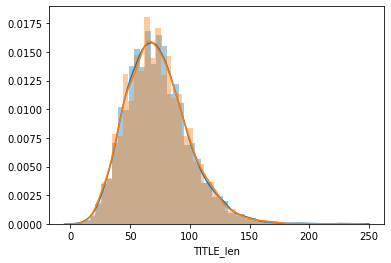

In [10]:
sns.distplot(train['TITLE_len'])
sns.distplot(test['TITLE_len'])

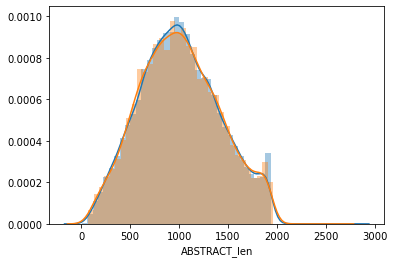

In [11]:
sns.distplot(train['ABSTRACT_len'])
sns.distplot(test['ABSTRACT_len'])

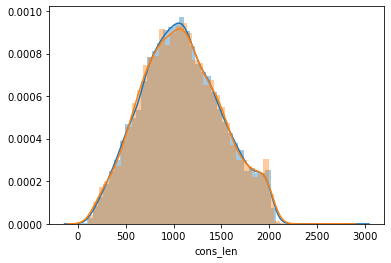

In [12]:
sns.distplot(train['cons_len'])
sns.distplot(test['cons_len'])

##### Title and abstract in both train and test have very similar distribution

### Functions for Text Preprocessing

In [13]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

In [14]:
def lower_(text):
    return text.lower()

In [15]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
def stop_words_removal(sentence):
  
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(sentence)
  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return (' '.join(filtered_sentence))

In [16]:
stemmer = SnowballStemmer("english")

def stemming(sentence):
    
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


In [17]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

### Apply Text Pre-Processing

In [18]:
#Removing Ascents
train['TITLE']=train['TITLE'].apply(remove_accented_chars)
test['TITLE']=test['TITLE'].apply(remove_accented_chars)

train['ABSTRACT']=train['ABSTRACT'].apply(remove_accented_chars)
test['ABSTRACT']=test['ABSTRACT'].apply(remove_accented_chars)

train['cons']=train['cons'].apply(remove_accented_chars)
test['cons']=test['cons'].apply(remove_accented_chars)

In [19]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons,cons_len
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,43,1912,Reconstructing Subject-Specific Effect Maps P...,1955
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,34,513,Rotation Invariance Neural Network Rotation i...,547


In [20]:
#Lower Casing the text
train['TITLE']=train['TITLE'].apply(lower_)
test['TITLE']=test['TITLE'].apply(lower_)

train['ABSTRACT']=train['ABSTRACT'].apply(lower_)
test['ABSTRACT']=test['ABSTRACT'].apply(lower_)

train['cons']=train['cons'].apply(lower_)
test['cons']=test['cons'].apply(lower_)

In [21]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons,cons_len
0,1,reconstructing subject-specific effect maps,predictive models allow subject-specific inf...,1,0,0,0,0,0,43,1912,reconstructing subject-specific effect maps p...,1955
1,2,rotation invariance neural network,rotation invariance and translation invarian...,1,0,0,0,0,0,34,513,rotation invariance neural network rotation i...,547


In [22]:
#Removing Special Characters
train['TITLE']=train['TITLE'].apply(remove_special_characters)
test['TITLE']=test['TITLE'].apply(remove_special_characters)

train['ABSTRACT']=train['ABSTRACT'].apply(remove_special_characters)
test['ABSTRACT']=test['ABSTRACT'].apply(remove_special_characters)

train['cons']=train['cons'].apply(remove_special_characters)
test['cons']=test['cons'].apply(remove_special_characters)

In [23]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons,cons_len
0,1,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infe...,1,0,0,0,0,0,43,1912,reconstructing subjectspecific effect maps pr...,1955
1,2,rotation invariance neural network,rotation invariance and translation invarian...,1,0,0,0,0,0,34,513,rotation invariance neural network rotation i...,547


In [24]:
#Stopwords removal
train['TITLE']=train['TITLE'].apply(stop_words_removal)
test['TITLE']=test['TITLE'].apply(stop_words_removal)

train['ABSTRACT']=train['ABSTRACT'].apply(stop_words_removal)
test['ABSTRACT']=test['ABSTRACT'].apply(stop_words_removal)

train['cons']=train['cons'].apply(stop_words_removal)
test['cons']=test['cons'].apply(stop_words_removal)

In [25]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons,cons_len
0,1,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infere...,1,0,0,0,0,0,43,1912,reconstructing subjectspecific effect maps pre...,1955
1,2,rotation invariance neural network,rotation invariance translation invariance gre...,1,0,0,0,0,0,34,513,rotation invariance neural network rotation in...,547


In [26]:
#Stemming
train['TITLE']=train['TITLE'].apply(stemming)
test['TITLE']=test['TITLE'].apply(stemming)

train['ABSTRACT']=train['ABSTRACT'].apply(stemming)
test['ABSTRACT']=test['ABSTRACT'].apply(stemming)

train['cons']=train['cons'].apply(stemming)
test['cons']=test['cons'].apply(stemming)

In [27]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons,cons_len
0,1,reconstruct subjectspecif effect map,predict model allow subjectspecif infer analyz...,1,0,0,0,0,0,43,1912,reconstruct subjectspecif effect map predict m...,1955
1,2,rotat invari neural network,rotat invari translat invari great valu imag r...,1,0,0,0,0,0,34,513,rotat invari neural network rotat invari trans...,547


In [28]:
#Writing the pre-processed text data
train.to_csv('new_train.csv')
test.to_csv('new_test.csv')

# Begin here

In [29]:
train=pd.read_csv('../input/preprocessed-av-topic-modelling/new_train.csv')
test=pd.read_csv('../input/preprocessed-av-topic-modelling/new_test.csv')

In [30]:
train['title_orig_len']=train['TITLE_len']
test['title_orig_len']=test['TITLE_len']

train['abs_orig_len']=train['ABSTRACT_len']
test['abs_orig_len']=test['ABSTRACT_len']

train['cons_orig_len']=train['cons_len']
test['cons_orig_len']=test['cons_len']

In [31]:
train['TITLE_len']=train['TITLE'].apply(len) 
test['TITLE_len']=test['TITLE'].apply(len) 

train['ABSTRACT_len']=train['ABSTRACT'].apply(len) 
test['ABSTRACT_len']=test['ABSTRACT'].apply(len) 

train['cons_len']=train['cons'].apply(len) 
test['cons_len']=test['cons'].apply(len) 

### Checking the change in length after pre-processing

In [32]:
train.describe()

,Unnamed: 0,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len,ABSTRACT_len,cons_len,title_orig_len,abs_orig_len,cons_orig_len
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10485.500000,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873,52.034999,636.346700,689.381699,72.897721,1009.103376,1082.001097
std,6054.239259,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317,18.669857,259.774748,264.557150,26.128903,408.641363,414.600584
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,25.000000,7.000000,7.000000,41.000000
25%,5242.750000,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,448.000000,498.000000,54.000000,714.000000,782.000000
50%,10485.500000,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,625.000000,678.000000,71.000000,989.000000,1063.000000
75%,15728.250000,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,63.000000,813.000000,870.000000,88.000000,1290.000000,1366.000000
max,20971.000000,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,175.000000,1712.000000,1783.000000,239.000000,2761.000000,2860.000000


In [33]:
test.describe()

,Unnamed: 0,ID,TITLE_len,ABSTRACT_len,cons_len,title_orig_len,abs_orig_len,cons_orig_len
count,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000
mean,4494.000000,25467.000000,52.047947,636.448882,689.496829,72.938147,1008.874847,1081.812994
std,2595.045118,2595.045118,18.694640,261.957677,266.948700,26.060040,411.366532,417.480060
min,0.000000,20973.000000,5.000000,44.000000,69.000000,8.000000,71.000000,106.000000
25%,2247.000000,23220.000000,39.000000,444.000000,494.000000,54.000000,706.000000,776.000000
50%,4494.000000,25467.000000,50.000000,624.000000,677.000000,71.000000,989.000000,1064.000000
75%,6741.000000,27714.000000,63.000000,818.000000,871.000000,88.000000,1295.000000,1372.000000
max,8988.000000,29961.000000,160.000000,1486.000000,1564.000000,233.000000,2571.000000,2682.000000


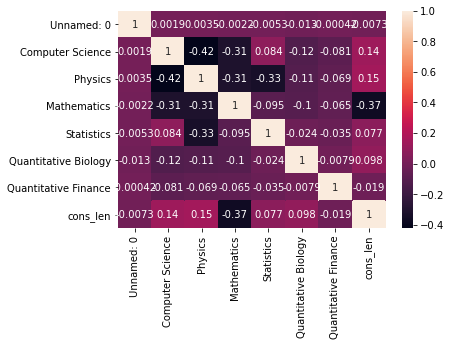

In [34]:
sns.heatmap(train.drop(['ID','title_orig_len','abs_orig_len','cons_orig_len','TITLE_len','ABSTRACT_len'],axis=1).corr(),annot=True)

### Train & Test Split

In [35]:
tr,ev = train_test_split(train,random_state=101,test_size=0.3, shuffle=True)

### TFIDF & Count Vectorization  

In [36]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(train['cons'].values) + list(test['cons'].values))

#Train
xtrain_tfv =  tfv.transform(tr['cons']) 
xvalid_tfv = tfv.transform(ev['cons'])

#Test
xtest_tfv= tfv.transform(test['cons'])

In [37]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(train['cons'].values) + list(test['cons'].values))

#Train
xtrain_ctv =  ctv.transform(tr['cons']) 
xvalid_ctv = ctv.transform(ev['cons'])

#Test
xtest_ctv= ctv.transform(test['cons'])

In [38]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [39]:
#targets that need to be predicted
targets=['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']

#Empty data frame for predictions
ev_pred=pd.DataFrame()
test_pred=pd.DataFrame()

### Simple Models using TFIDF & Vectors 

In [40]:
#Using LogisticRegression one at a time on tf_idf
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using LogisticRegression
    classifier = LogisticRegression()
    classifier.fit(xtrain_tfv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_tfv)
    test_pred[t] = classifier.predict(xtest_tfv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_logit.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.832421875
Physics
0.8597899938233479
Mathematics
0.8040103492884864
Statistics
0.7123388581952118
Quantitative Biology
0.0
Quantitative Finance
0.0
Your submission was successfully saved!


##### Accuracy: 0.7993270848353762

In [41]:
#Using LogisticRegression one at a time on ctv
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using LogisticRegression
    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(xtrain_ctv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_ctv)
    test_pred[t] = classifier.predict(xtest_ctv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('ctv_logit.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8208750245242299
Physics
0.8849661665195645
Mathematics
0.8194070080862533
Statistics
0.7514411664971177
Quantitative Biology
0.3793103448275862
Quantitative Finance
0.3789473684210526
Your submission was successfully saved!


##### Accuracy: 0.8049348230912476

In [42]:
#Using MultinomialNB one at a time on tf_idf
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using MultinomialNB
    classifier = MultinomialNB()
    classifier.fit(xtrain_tfv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_tfv)
    test_pred[t] = classifier.predict(xtest_tfv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_mnb.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8144778481012658
Physics
0.7813985064494229
Mathematics
0.6038195855343357
Statistics
0.23562570462232246
Quantitative Biology
0.0
Quantitative Finance
0.0
Your submission was successfully saved!


##### Accuracy: 0.676923076923077

In [43]:
#Using MultinomialNB one at a time on ctv
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using MultinomialNB
    classifier = MultinomialNB()
    classifier.fit(xtrain_ctv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_ctv)
    test_pred[t] = classifier.predict(xtest_ctv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('ctv_mnb.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8503767491926805
Physics
0.8782243551289742
Mathematics
0.7930922124470512
Statistics
0.7669452181987002
Quantitative Biology
0.023529411764705882
Quantitative Finance
0.0
Your submission was successfully saved!


##### Accuracy: 0.8092842442259318

In [44]:
#Using SVC One at a time
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using XGB
    classifier = SVC() 
    classifier.fit(xtrain_svd_scl, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_svd_scl)
    test_pred[t] = classifier.predict(xtest_svd_scl)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_svc.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8405687203791469
Physics
0.8879789412108805
Mathematics
0.8240857503152585
Statistics
0.7899437644723784
Quantitative Biology
0.2564102564102564
Quantitative Finance
0.5585585585585585
Your submission was successfully saved!


##### Accuracy: 0.821267230394996

In [45]:
#Using XGBoost one at a time
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using XGB
    classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
    classifier.fit(xtrain_tfv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_tfv)
    test_pred[t] = classifier.predict(xtest_tfv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_xgb.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8142002701138337
Physics
0.8515389257694629
Mathematics
0.7996272134203168
Statistics
0.746540668241647
Quantitative Biology
0.2748815165876777
Quantitative Finance
0.5233644859813084
Your submission was successfully saved!


##### Accuracy: 0.7930549038010324

In [46]:
#Using XGBClassifier one at a time on ctv
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using XGBClassifier
    classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
    classifier.fit(xtrain_ctv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_ctv)
    test_pred[t] = classifier.predict(xtest_ctv)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('ctv_xgb.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8074389771406432
Physics
0.8565400843881856
Mathematics
0.8013488657265482
Statistics
0.7452036351396837
Quantitative Biology
0.3148148148148148
Quantitative Finance
0.49523809523809526
Your submission was successfully saved!


##### Accuracy: 0.7930022308324527

In [47]:
#Using XGBoost on SVD components
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using XGB789746001881468
    classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
    classifier.fit(xtrain_svd, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_svd)
    test_pred[t] = classifier.predict(xtest_svd)

for t in targets:
    print(t)
    print(f1_score(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_svd_xgb.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
0.8346277704110627
Physics
0.8851213095586087
Mathematics
0.8154559505409583
Statistics
0.7739130434782608
Quantitative Biology
0.28846153846153844
Quantitative Finance
0.49523809523809526
Your submission was successfully saved!


##### Accuracy: 0.8173573642520952

In [48]:
#Using XGBoost on SVD components
for t in targets:

    y_train=tr[t]
    y_test=ev[t]

    #using XGB
    classifier = xgb.XGBClassifier(nthread=10)
    classifier.fit(xtrain_svd, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_svd)
    test_pred[t] = classifier.predict(xtest_svd)

for t in targets:
    print(t)
    print(classification_report(ev[t],ev_pred[t]))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_svd_xgb2.csv', index=False)
print("Your submission was successfully saved!")

Computer Science
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3714
           1       0.81      0.84      0.82      2578

    accuracy                           0.85      6292
   macro avg       0.85      0.85      0.85      6292
weighted avg       0.85      0.85      0.85      6292

Physics
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4511
           1       0.91      0.85      0.88      1781

    accuracy                           0.93      6292
   macro avg       0.93      0.91      0.92      6292
weighted avg       0.93      0.93      0.93      6292

Mathematics
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      4586
           1       0.84      0.77      0.81      1706

    accuracy                           0.90      6292
   macro avg       0.88      0.86      0.87      6292
weighted avg       0.90      0.90    

##### Accuracy: 0.8100712807541964

### Using Grid Serach CV

In [49]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [50]:
# Next we need a grid of parameters:

param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [51]:
for t in targets:

    y_train=tr[t]
    
    print('\n For',t)
    # Initialize Grid Search Model
    model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_micro',
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

    # Fit Grid Search Model
    model.fit(xtrain_tfv, y_train)  # we can use the full data here but im only using xtrain
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
'''
    Results from GridSerach CV
    
    For Computer Science:
    Best score: 0.857
    Best parameters set:
        lr__C: 0.1
        lr__penalty: 'l2'
        svd__n_components: 180

    For Physics:
    Best score: 0.932
    Best parameters set:
        lr__C: 1.0
        lr__penalty: 'l2'
        svd__n_components: 120
    
    For Mathematics:
    Best score: 0.902
    Best parameters set:
        lr__C: 0.1
        lr__penalty: 'l2'
        svd__n_components: 120
    
    For Statistics:
    Best score: 0.881
    Best parameters set:
        lr__C: 1.0
        lr__penalty: 'l2'
        svd__n_components: 180
    
    For Quantitative Biology:
    Best score: 0.974
    Best parameters set:
        lr__C: 10
        lr__penalty: 'l2'
        svd__n_components: 180

    For Quantitative Finance:
    Best score: 0.990
    Best parameters set:
        lr__C: 1.0
        lr__penalty: 'l2'
        svd__n_components: 120

'''


 For Computer Science
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.6min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.859
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180

 For Physics
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.4min remaining:   40.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.0min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.930
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'
	svd__n_components: 180

 For Mathematics
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.6min remaining:   43.7s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.901
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180

 For Statistics
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.4min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.0min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.878
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180

 For Quantitative Biology
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.6min remaining:   43.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.973
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180

 For Quantitative Finance
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  3.3min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.9min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.990
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 120


"\n    Results from GridSerach CV\n    \n    For Computer Science:\n    Best score: 0.857\n    Best parameters set:\n        lr__C: 0.1\n        lr__penalty: 'l2'\n        svd__n_components: 180\n\n    For Physics:\n    Best score: 0.932\n    Best parameters set:\n        lr__C: 1.0\n        lr__penalty: 'l2'\n        svd__n_components: 120\n    \n    For Mathematics:\n    Best score: 0.902\n    Best parameters set:\n        lr__C: 0.1\n        lr__penalty: 'l2'\n        svd__n_components: 120\n    \n    For Statistics:\n    Best score: 0.881\n    Best parameters set:\n        lr__C: 1.0\n        lr__penalty: 'l2'\n        svd__n_components: 180\n    \n    For Quantitative Biology:\n    Best score: 0.974\n    Best parameters set:\n        lr__C: 10\n        lr__penalty: 'l2'\n        svd__n_components: 180\n\n    For Quantitative Finance:\n    Best score: 0.990\n    Best parameters set:\n        lr__C: 1.0\n        lr__penalty: 'l2'\n        svd__n_components: 120\n\n"

In [52]:
# Using Grid Search Results:

svd_comp={'Computer Science': 180, 'Physics': 120, 'Mathematics': 120, 'Statistics': 180, 'Quantitative Biology': 180, 'Quantitative Finance':120}
lr_c={'Computer Science': 0.1, 'Physics': 1.0, 'Mathematics': 0.1, 'Statistics': 1, 'Quantitative Biology': 10, 'Quantitative Finance':1}
lr_pen={'Computer Science': 'l2', 'Physics': 'l2', 'Mathematics': 'l2', 'Statistics': 'l2', 'Quantitative Biology': 'l2', 'Quantitative Finance':'l2'}

for t in targets:
    
    y_train=tr[t]
    
    # Initialize SVD
    svd = TruncatedSVD(n_components=svd_comp[t])
    
    # Initialize the standard scaler 
    scl = preprocessing.StandardScaler()

    # We will use logistic regression here..
    lr_model = LogisticRegression(C=lr_c[t],penalty=lr_pen[t])
    
    svd.fit(xtrain_tfv)
    xtrain_svd = svd.transform(xtrain_tfv)
    xvalid_svd = svd.transform(xvalid_tfv)
    xtest_svd = svd.transform(xtest_tfv)

    # Scale the data obtained from SVD. Renaming variable to reuse without scaling.
    scl.fit(xtrain_svd)
    xtrain_svd_scl = scl.transform(xtrain_svd)
    xvalid_svd_scl = scl.transform(xvalid_svd)
    xtest_svd_scl = scl.transform(xtest_svd)
    
    # Model Fit
    lr_model.fit(xtrain_svd_scl, y_train)  
    
    ev_pred[t] = lr_model.predict(xvalid_svd_scl)
    test_pred[t] = lr_model.predict(xtest_svd_scl)

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_svd_logit_gsv.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


##### Accuracy: 0.807033888436008

In [53]:
# Lightgbm
import lightgbm as lgb

In [54]:
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]
    
    clf = lgb.LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=42,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    
    clf.fit(xtrain_svd_scl, y_train, early_stopping_rounds=100, eval_set=[(xtrain_svd_scl, y_train), (xvalid_svd_scl, y_test)], eval_metric='f1_micro', verbose=True)

    eval_score = f1_score(y_test, clf.predict(xvalid_svd_scl))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = clf.predict(xvalid_svd_scl)
    test_pred[t] = clf.predict(xtest_svd_scl)

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('tf_idf_svd_lgbm.csv', index=False)
print("Your submission was successfully saved!")

[1]	training's binary_logloss: 0.661549	valid_1's binary_logloss: 0.662095
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.648174	valid_1's binary_logloss: 0.649282
[3]	training's binary_logloss: 0.639134	valid_1's binary_logloss: 0.640862
[4]	training's binary_logloss: 0.635296	valid_1's binary_logloss: 0.637973
[5]	training's binary_logloss: 0.622755	valid_1's binary_logloss: 0.626132
[6]	training's binary_logloss: 0.610921	valid_1's binary_logloss: 0.614938
[7]	training's binary_logloss: 0.604197	valid_1's binary_logloss: 0.609124
[8]	training's binary_logloss: 0.594203	valid_1's binary_logloss: 0.599899
[9]	training's binary_logloss: 0.584159	valid_1's binary_logloss: 0.590206
[10]	training's binary_logloss: 0.574784	valid_1's binary_logloss: 0.581303
[11]	training's binary_logloss: 0.565697	valid_1's binary_logloss: 0.572624
[12]	training's binary_logloss: 0.556407	valid_1's binary_logloss: 0.563824
[13]	training's binary_logloss: 0.5

##### Accuracy: 0.812694032424974

### Word Vectors

In [55]:
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [06:00, 6095.45it/s]

Found 2196017 word vectors.


In [56]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())


In [57]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(tr['cons'])]
xvalid_glove = [sent2vec(x) for x in tqdm(ev['cons'])]
xtest_glove = [sent2vec(x) for x in tqdm(test['cons'])]


100%|██████████| 8989/8989 [00:17<00:00, 511.65it/s]


In [58]:
# Fitting a simple xgboost on glove features
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    clf = xgb.XGBClassifier(nthread=10, silent=False)
    clf.fit(np.array(xtrain_glove), y_train)
    eval_score = f1_score(y_test, clf.predict(np.array(xvalid_glove)))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = clf.predict(np.array(xvalid_glove))
    test_pred[t] = clf.predict(np.array(xtest_glove))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('glove_xgb.csv', index=False)
print("Your submission was successfully saved!")


[09:21:29] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Eval ACC: 0.7887981330221705
[09:22:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Eval ACC: 0.8425506195225143
[09:22:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ve

##### Accuracy: 0.762793995981563

In [59]:
# Fitting a simple xgboost on glove features
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
    clf.fit(np.array(xtrain_glove), y_train)
    eval_score = f1_score(y_test, clf.predict(np.array(xvalid_glove)))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = clf.predict(np.array(xvalid_glove))
    test_pred[t] = clf.predict(np.array(xtest_glove))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('glove_xgb2.csv', index=False)
print("Your submission was successfully saved!")


[09:24:49] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Eval ACC: 0.7987663839629915
[09:25:52] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Eval ACC: 0.8437973915680922
[09:26:53] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ve

##### Accuracy: 0.768516313407954

### Deep Learning

In [60]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [61]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units=1,activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [62]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [63]:
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    
    model.fit(x=xtrain_glove_scl,
              y=y_train, 
              batch_size=256, 
              epochs=500, 
              verbose=1, 
              validation_data=(xvalid_glove_scl, y_test),
              callbacks=[early_stop]
             )
        
    eval_score = f1_score(y_test, model.predict(xvalid_glove_scl).astype('int'))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = np.array(model.predict(xvalid_glove_scl))
    test_pred[t] = np.array(model.predict(xtest_glove_scl))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('glove_nn.csv', index=False)
print("Your submission was successfully saved!")


Epoch 1/500
58/58 [==============================] - 1s 16ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/500
58/58 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/500
58/58 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/500
58/58 [========

##### Accuracy: 0.343620451404883

### Proceeding to LSTMs

In [64]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(train['cons']) + list(test['cons']))
xtrain_seq = token.texts_to_sequences(tr['cons'])
xvalid_seq = token.texts_to_sequences(ev['cons'])
xtest_seq = token.texts_to_sequences(test['cons'])


# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [65]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


100%|██████████| 89145/89145 [00:00<00:00, 160493.57it/s]


In [66]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [67]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [68]:
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    
    model.fit(xtrain_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, y_test), callbacks=[earlystop])

        
    eval_score = f1_score(y_test, model.predict(xvalid_pad).astype('int'))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = np.array(model.predict(xvalid_pad))
    test_pred[t] = np.array(model.predict(xtest_pad))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('lstm_nn.csv', index=False)
print("Your submission was successfully saved!")

Epoch 1/100
29/29 [==============================] - 27s 938ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 27s 921ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 27s 919ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 28s 956ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.5812852311161217
Epoch 1/100
29/29 [==============================] - 32s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 27s 923ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 27s 945ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 27s 917ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.44122383252818037
Epoch 1/100
29/29 [==============================] - 27s 936ms/s

##### Accuracy: 0.34362045140488257

In [69]:
xtrain_pad.shape

(14680, 70)

### Bi-directional LSTM

In [70]:
# A simple bidirectional LSTM with glove embeddings and two dense layers

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [71]:
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    
    model.fit(xtrain_pad, y=y_train, batch_size=512, epochs=100,verbose=1, validation_data=(xvalid_pad, y_test), callbacks=[earlystop])
    
    eval_score = f1_score(y_test, model.predict(xvalid_pad).astype('int'))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = np.array(model.predict(xvalid_pad))
    test_pred[t] = np.array(model.predict(xtest_pad))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('bilstm_nn.csv', index=False)
print("Your submission was successfully saved!")



Epoch 1/100
29/29 [==============================] - 142s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 141s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 139s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 142s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.5812852311161217
Epoch 1/100
29/29 [==============================] - 140s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 138s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 139s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 142s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.44122383252818037
Epoch 1/100
29/29 [==============================] - 145s 5s/step - loss: 0.0

##### Accuracy: 0.34362045140488257

### GRU with gloves

In [72]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [73]:
for t in targets:
    
    y_train=tr[t]
    y_test=ev[t]

    
    model.fit(xtrain_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, y_test), callbacks=[earlystop])
    
    eval_score = f1_score(y_test, model.predict(xvalid_pad).astype('int'))
    
    print('Eval ACC: {}'.format(eval_score))
    
    ev_pred[t] = np.array(model.predict(xvalid_pad))
    test_pred[t] = np.array(model.predict(xtest_pad))

output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('gru_nn.csv', index=False)
print("Your submission was successfully saved!")



Epoch 1/100
29/29 [==============================] - 123s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 122s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 123s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 122s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.5812852311161217
Epoch 1/100
29/29 [==============================] - 121s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 122s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 124s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 121s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Eval ACC: 0.44122383252818037
Epoch 1/100
29/29 [==============================] - 121s 4s/step - loss: 0.0

### Reference:

1) https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html#:~:text=Removing%20Special%20Characters,be%20used%20to%20remove%20them.

2) https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

3) https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle